In [2]:
import os
import shutil
import random
from pathlib import Path

# Source directories
main_cat = "./data/PetImages/Cat"
main_dog = "./data/PetImages/Dog"
main_men = "./data/gender_dataset/men"
main_women = "./data/gender_dataset/women"

# Target directories
target_train_cat = "./data/train/cat"
target_train_dog = "./data/train/dog"
target_train_person = "./data/train/person"

target_test_cat = "./data/test/cat"
target_test_dog = "./data/test/dog"
target_test_person = "./data/test/person"

# Function to split and copy images
def split_and_copy(src_dirs, train_dir, test_dir, split_ratio=0.8):
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    all_files = []
    for src in src_dirs:
        all_files += [str(Path(src) / f) for f in os.listdir(src) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    random.shuffle(all_files)
    split_point = int(len(all_files) * split_ratio)
    train_files = all_files[:split_point]
    test_files = all_files[split_point:]

    print(f"Processing {len(all_files)} images → {len(train_files)} train / {len(test_files)} test")

    for files, target in [(train_files, train_dir), (test_files, test_dir)]:
        for f in files:
            try:
                shutil.copy(f, target)
            except Exception as e:
                print(f"Error copying {f}: {e}")

# Split cats
split_and_copy([main_cat], target_train_cat, target_test_cat)

# Split dogs
split_and_copy([main_dog], target_train_dog, target_test_dog)

# Split people (men + women together)
split_and_copy([main_men, main_women], target_train_person, target_test_person)


Processing 12499 images → 9999 train / 2500 test
Processing 12499 images → 9999 train / 2500 test
Processing 1668 images → 1334 train / 334 test


In [3]:
image_dir="data/train"
for label,class_dir in enumerate(os.listdir(image_dir)):
    print(label,class_dir)

0 person
1 cat
2 dog


In [4]:
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [5]:
class ImageDataset(Dataset):
    def __init__(self,image_dir,transform=None):
        self.image_dir=image_dir
        self.image_paths=[]
        self.labels=[]  ### labes 0/1/2
        self.class_name={}
        self.transform=transform

        for label,class_dir in enumerate(os.listdir(image_dir)):
            self.class_name[label]=class_dir
            class_path=os.path.join(image_dir,class_dir)
            for image_name in os.listdir(class_path):
                self.image_paths.append(os.path.join(class_path,image_name))
                self.labels.append(label)
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self,idx):
        img_path=self.image_paths[idx]
        image=Image.open(img_path).convert("RGB")
        label=self.labels[idx]
        if self.transform is not None:
            image=self.transform(image)
        return image,label

In [6]:
transform=transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5])
])

In [7]:
train_image_dir="/home/sachchida/gitrepo/computervision/cnn/data/train"
test_image_dir="/home/sachchida/gitrepo/computervision/cnn/data/test"

train_image_dataset=ImageDataset(image_dir=train_image_dir,transform=transform)
test_image_dataset=ImageDataset(image_dir=test_image_dir,transform=transform)

In [8]:
train_image_loader=DataLoader(dataset=train_image_dataset,batch_size=32,shuffle=True)
test_image_loader=DataLoader(dataset=test_image_dataset,batch_size=32,shuffle=True)

In [9]:
for images,labels in train_image_loader:
    print(images.shape, labels.shape)
    break

torch.Size([32, 3, 128, 128]) torch.Size([32])


In [10]:
import matplotlib.pyplot as plt
import numpy as np

print(train_image_dataset.class_name)
print(test_image_dataset.class_name)

{0: 'person', 1: 'cat', 2: 'dog'}
{0: 'person', 1: 'cat', 2: 'dog'}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].


torch.Size([32, 3, 128, 128]) torch.Size([32])
dog
(128, 128, 3)
2


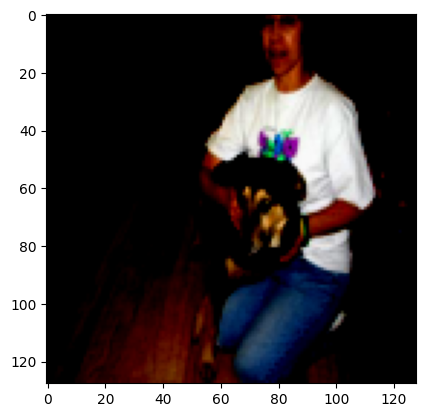

In [11]:
for images, labels in train_image_loader:
    print(images.shape,labels.shape)
    img=images[0].numpy()
    label=labels[0].item()
    print(train_image_dataset.class_name[label])
    img=np.transpose(img,(1,2,0))
    print(img.shape)
    print(label)
    plt.imshow(img,vmin=0,vmax=255)
    break

### Custom CNN Architecture

In [12]:
import torch.nn as nn
import torch.optim as optim

In [13]:
class CustomCnnModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(CustomCnnModel, self).__init__()
        self.input_dim = input_dim
        self.num_classes = num_classes

        self.conv_layers = nn.Sequential(
            # Convolution Block 1
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Convolution Block 2
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Convolution Block 3
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Convolution Block 4
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Get flattened output size dynamically
        self.to_linear = self._get_conv_output(input_dim)

        self.fc_layer = nn.Sequential(
            nn.Linear(self.to_linear, 512),
            nn.ReLU(),
            ## nn.Dropout(0.2),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, self.num_classes)
        )

    def _get_conv_output(self, input_dim):
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, input_dim, input_dim)
            output = self.conv_layers(dummy_input)
            return output.view(1, -1).size(1)  # number of flattened features

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layer(x)
        return x


In [15]:
import torch

In [16]:
## Initialize model
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
print(device)
model=CustomCnnModel(input_dim=128,num_classes=3).to(device)

cuda


In [17]:
print(model)

CustomCnnModel(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [18]:
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)

In [88]:
### Training loop
epochs=40
for epoch in range(epochs):
    model.train()
    running_loss=0.0
    for images,labels in train_image_loader:
        images,labels=images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs=model(images)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
    print(f"Epoch {epoch+1}/{epochs}, loss : {running_loss/len(train_image_loader)}")



/home/sachchida/anaconda3/envs/torch-cuda12_8/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 1/40, loss : 0.17463116945178658
Epoch 2/40, loss : 0.14106166118844635
Epoch 3/40, loss : 0.11464251604703096
Epoch 4/40, loss : 0.09074137479688929
Epoch 5/40, loss : 0.07287063413243286
Epoch 6/40, loss : 0.059570864578837854
Epoch 7/40, loss : 0.05065146905357771
Epoch 8/40, loss : 0.03975169766192238
Epoch 9/40, loss : 0.03912611532064294
Epoch 10/40, loss : 0.038407053428795995
Epoch 11/40, loss : 0.026706285310273213
Epoch 12/40, loss : 0.02524535119320373
Epoch 13/40, loss : 0.023579863564569523
Epoch 14/40, loss : 0.02773709011067376
Epoch 15/40, loss : 0.020094395879284983
Epoch 16/40, loss : 0.022985503423028388
Epoch 17/40, loss : 0.017690244298868833
Epoch 18/40, loss : 0.019075541069864234
Epoch 19/40, loss : 0.022642856537958823


KeyboardInterrupt: 

In [89]:
model.state_dict() ### all the weights and biases
torch.save(model.state_dict(),"cnn_model.pth")

In [94]:
## Evaluate model
model.eval()
correct=0
total=0
with torch.no_grad():
    for images,labels in test_image_loader:
        images,labels=images.to(device), labels.to(device)
        outputs=model(images)
        _,predicted=torch.max(outputs,1)
        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()

print(f"Test Accurraccy is {100*correct/total:.2f}%")

Test Accurraccy is 98.00%


In [19]:
## Load model
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CustomCnnModel(input_dim=128, num_classes=3)
model.load_state_dict(torch.load("cnn_model.pth", map_location=device))
model.to(device)
model.eval()  # optional: set to evaluation mode

CustomCnnModel(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [20]:
import cv2

In [37]:
class ImageClassifier:
    def __init__(self,model_path,class_name):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model=CustomCnnModel(input_dim=128,num_classes=3)
        self.model.load_state_dict(torch.load(model_path,map_location=self.device))
        self.model.to(self.device)
        self.model.eval()
        self.class_names=class_name
        self.transform=transforms.Compose([
            transforms.Resize((128,128)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5])
        ])
    def predict(self,image_path):
        image=Image.open(image_path).convert("RGB")
        input_tensor=self.transform(image).unsqueeze(0).to(self.device) ## [3,128,128] Model expect in batches but currently there is no batches
        ### so we unsqueeze at position 0 it add [1,3,128,128] Transform converts to tensor 
        with torch.no_grad():
            output=self.model(input_tensor)
            _,predicted=torch.max(output,1)
        label=self.class_names[predicted.item()]
        img=cv2.imread(image_path)
        cv2.putText(img, label, (10, 30), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 0, 0), 2)
        cv2.imwrite("output_image.jpg",img)
        return label


Image classified as cat


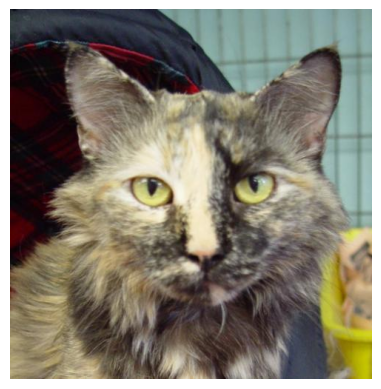

In [41]:
classifier=ImageClassifier("cnn_model.pth",train_image_dataset.class_name)
label=classifier.predict("/home/sachchida/gitrepo/computervision/cnn/data/train/cat/10.jpg")
print(f"Image classified as {label}")
img = cv2.imread("/home/sachchida/gitrepo/computervision/cnn/data/train/cat/10.jpg")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.axis('off')  # optional: hide axes
plt.show()